In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

**Exploring the dataset**

In [2]:
data = pd.read_csv("/kaggle/input/spam-detection/spam.csv",encoding='latin-1')
data.head(n=10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


**Distribution spam/non spam plots**

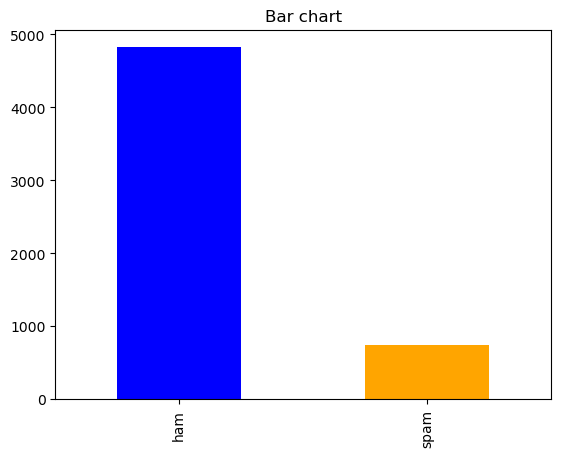

In [3]:
count_Class=pd.value_counts(data["v1"], sort=True)
count_Class.plot(kind='bar',color=['blue','orange'])
plt.title('Bar chart')
plt.show()

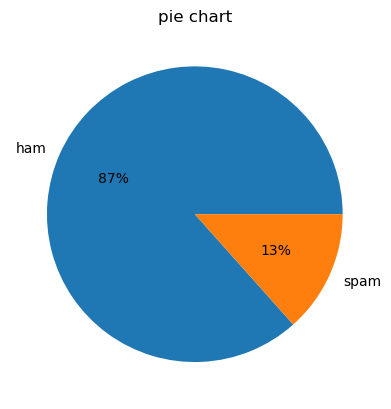

In [4]:
count_Class.plot(kind='pie',autopct='%1.0f%%')
plt.title('pie chart')
plt.ylabel('')
plt.show()

**Text Analytics**

In [5]:
count1=Counter(" ".join(data[data['v1']=='ham']['v2']).split()).most_common(20)
df1=pd.DataFrame.from_dict(count1)
df1=df1.rename(columns={0:"words in non-spam",1 : "count"})
count2=Counter(" ".join(data[data['v1']=='spam']['v2']).split()).most_common(20)
df2=pd.DataFrame.from_dict(count2)
df2=df2.rename(columns={0:"words in spam",1 : "count_"})

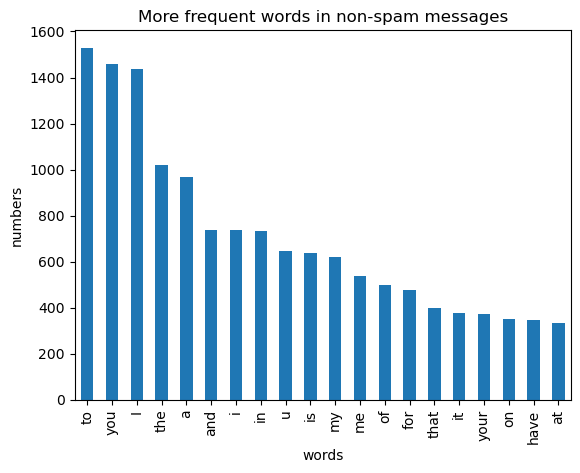

In [6]:
df1.plot.bar(legend=False)
y_pos=np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos,df1["words in non-spam"])
plt.title("More frequent words in non-spam messages")
plt.xlabel('words')
plt.ylabel('numbers')
plt.show()

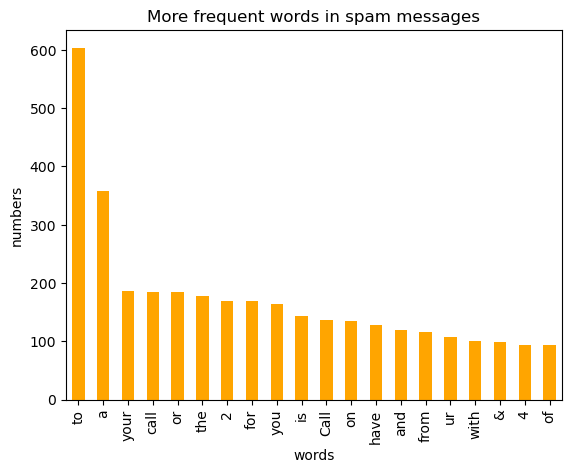

In [7]:
df2.plot.bar(legend=False,color='orange')
y_pos=np.arange(len(df2["words in spam"]))
plt.xticks(y_pos,df2["words in spam"])
plt.title("More frequent words in spam messages")
plt.xlabel('words')
plt.ylabel('numbers')
plt.show()

In [8]:
f=feature_extraction.text.CountVectorizer(stop_words='english')
X=f.fit_transform(data['v2'])
np.shape(X)

(5572, 8404)

**Predictive Analysis**

In [9]:
data['v1']=data['v1'].map({'spam':1,"ham":0})
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,data['v1'],test_size=0.33,random_state=42)
print([np.shape(X_train),np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


**Multinomial naive bayes classifier**

In [10]:
list_alpha=np.arange(1/100000,20,0.11)
score_train=np.zeros(len(list_alpha))
score_test=np.zeros(len(list_alpha))
recall_test=np.zeros(len(list_alpha))
precision_test=np.zeros(len(list_alpha))
count=0
for alpha in list_alpha:
    bayes=naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train,y_train)
    score_train[count]=bayes.score(X_train,y_train)
    score_test[count]=bayes.score(X_test,y_test)
    recall_test[count]=metrics.recall_score(y_test,bayes.predict(X_test))
    precision_test[count]=metrics.precision_score(y_test,bayes.predict(X_test))
    count=count+1

In [11]:
matrix=np.matrix(np.c_[list_alpha,score_train,score_test,recall_test,precision_test])
models=pd.DataFrame(data=matrix,columns=['alpha','Train Accuracy','Test Accuracy','Test Recall','Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250


selected the model with the most test precision

In [12]:
best_index=models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [13]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0


Between these models with the highest possible precision, we are going to select which has more test accuracy

In [14]:
best_index=models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes=naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train,y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

**Confusion matrix with naive bayes classifier**

In [15]:
m_confusion_test=metrics.confusion_matrix(y_test,bayes.predict(X_test))
pd.DataFrame(data=m_confusion_test,columns=['Predicted 0','predicted 1'],index=['Actual 0','Actual 1'])

,Predicted 0,predicted 1
Actual 0,1587,0
Actual 1,56,196


In [16]:
list_C=np.arange(500,2000,100)
score_train=np.zeros(len(list_C))
score_test=np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

In [17]:
matrix=np.matrix(np.c_[list_C,score_train,score_test,recall_test,precision_test])
models=pd.DataFrame(data=matrix,columns=['C','Train Accuracy','Test Accuracy','Test Recall','Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,1.0,0.979337,0.853175,0.99537
1,600.0,1.0,0.979337,0.853175,0.99537
2,700.0,1.0,0.979337,0.853175,0.99537
3,800.0,1.0,0.979337,0.853175,0.99537
4,900.0,1.0,0.979337,0.853175,0.99537
5,1000.0,1.0,0.979337,0.853175,0.99537
6,1100.0,1.0,0.979337,0.853175,0.99537
7,1200.0,1.0,0.979337,0.853175,0.99537
8,1300.0,1.0,0.979337,0.853175,0.99537
9,1400.0,1.0,0.979337,0.853175,0.99537


In [18]:
best_index=models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.979337
Test Recall         0.853175
Test Precision      0.995370
Name: 0, dtype: float64

In [19]:
models[models['Test Precision']==1].head(n=5)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision


In [20]:
m_confision_test=metrics.confusion_matrix(y_test,svc.predict(X_test))
pd.DataFrame(data=m_confusion_test,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])


,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196
